In [16]:
file = open("car_evaluation.csv", "r")
lines = file.readlines()
numified_data = []
numified_target = []

data_types = {}
x = 0
for line in lines:
    line = line.replace("\n", "")
    data = []
    for splitted in line.split(",")[:-1]:
        if splitted not in data_types:
            data_types[splitted] = x
            x = x + 1
        data.append(data_types[splitted])
    numified_data.append(data)
    numified_target.append(0 if line.split(",")[-1] == 'unacc' else 1)

print(data_types)
print(numified_data[:10])
print(numified_target[:10])


{'vhigh': 0, '2': 1, 'small': 2, 'low': 3, 'med': 4, 'high': 5, 'big': 6, '4': 7, 'more': 8, '3': 9, '5more': 10}
[[0, 0, 1, 1, 2, 3], [0, 0, 1, 1, 2, 4], [0, 0, 1, 1, 2, 5], [0, 0, 1, 1, 4, 3], [0, 0, 1, 1, 4, 4], [0, 0, 1, 1, 4, 5], [0, 0, 1, 1, 6, 3], [0, 0, 1, 1, 6, 4], [0, 0, 1, 1, 6, 5], [0, 0, 1, 7, 2, 3]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(numified_data, numified_target, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(random_state=100)
model = clf.fit(X_train, y_train)
res_pred = clf.predict(X_test)
dt_score = metrics.accuracy_score(y_test, res_pred)
print(dt_score)


0.9971098265895953


In [20]:
text_presentation = tree.export_text(clf)
print(text_presentation)

|--- feature_5 <= 3.50
|   |--- class: 0
|--- feature_5 >  3.50
|   |--- feature_3 <= 4.00
|   |   |--- class: 0
|   |--- feature_3 >  4.00
|   |   |--- feature_1 <= 1.50
|   |   |   |--- feature_0 <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  1.50
|   |   |   |   |--- feature_0 <= 4.50
|   |   |   |   |   |--- feature_5 <= 4.50
|   |   |   |   |   |   |--- feature_4 <= 3.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_4 >  3.00
|   |   |   |   |   |   |   |--- feature_4 <= 5.00
|   |   |   |   |   |   |   |   |--- feature_2 <= 4.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_2 >  4.00
|   |   |   |   |   |   |   |   |   |--- feature_3 <= 7.50
|   |   |   |   |   |   |   |   |   |   |--- feature_2 <= 9.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_2 >  9.50
|   |   |   |   |   |   |   |   |   | 

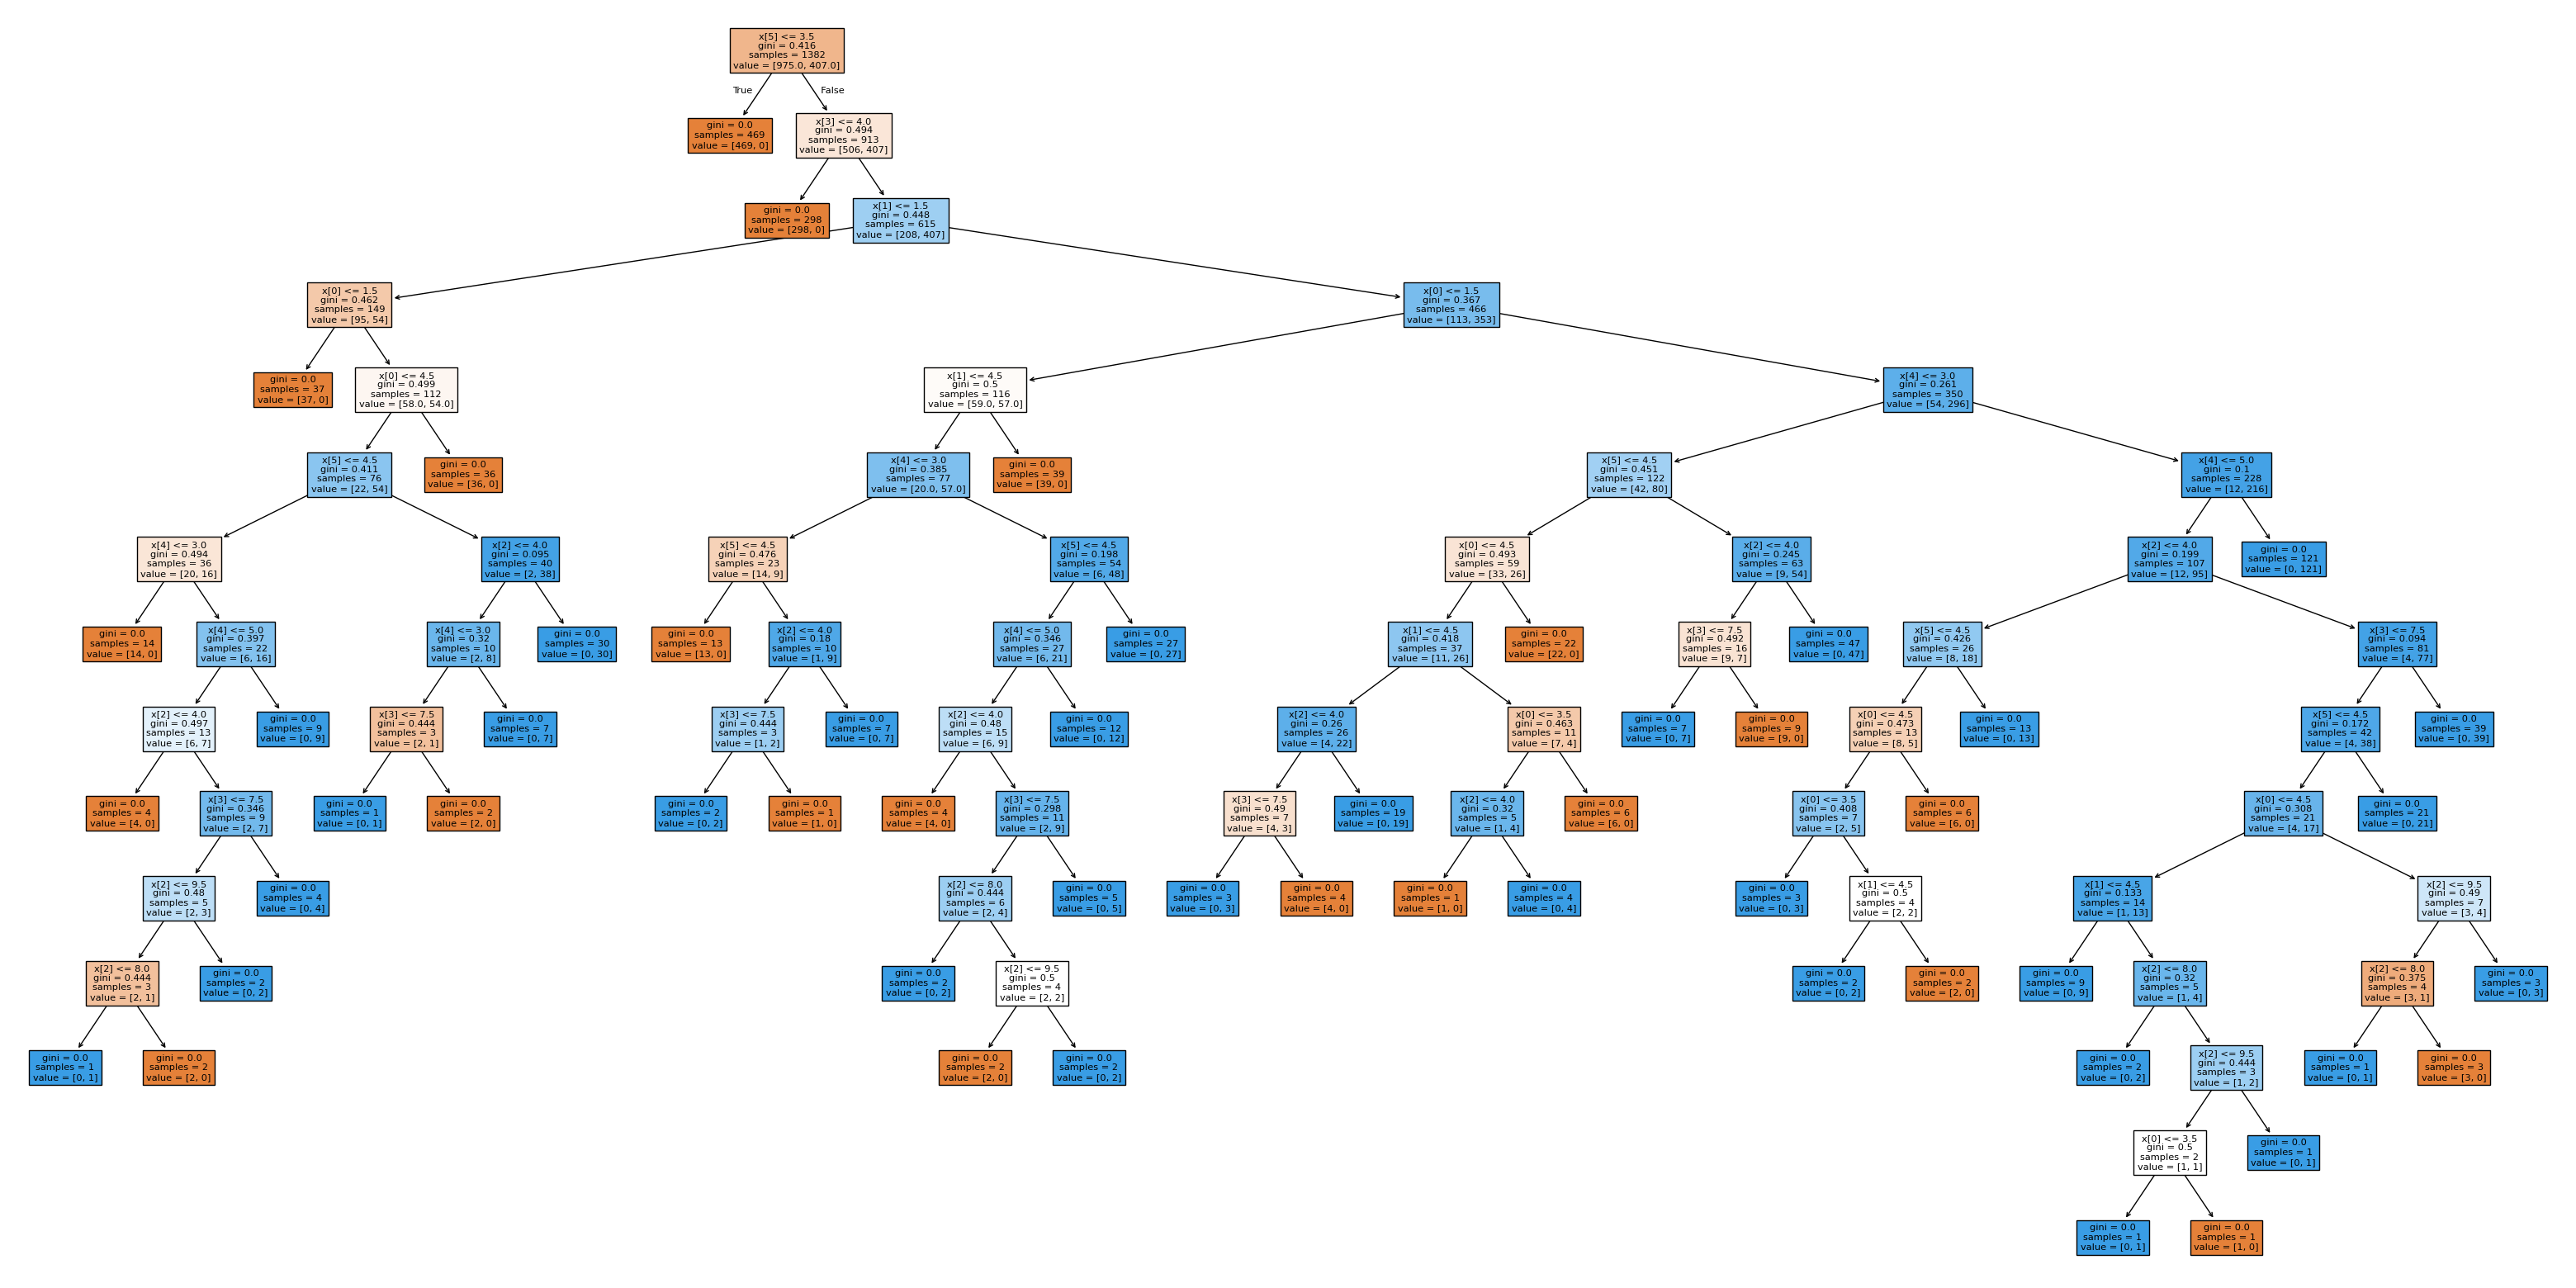

<Figure size 640x480 with 0 Axes>

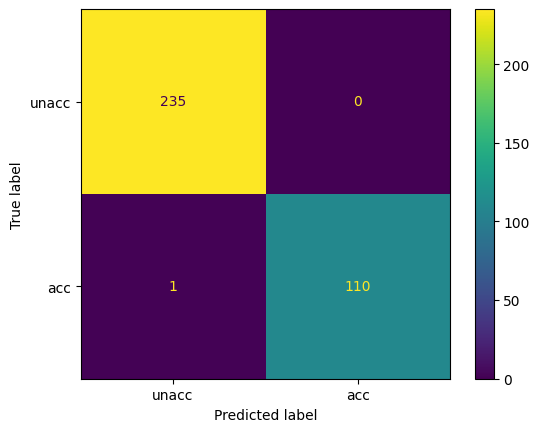

In [22]:
import matplotlib.pyplot as plt

tree_graph = plt.figure(figsize=(40, 20))
_ = tree.plot_tree(clf,
                   filled=True)
tree_graph.savefig("decistion_tree.png")

plt.figure()
confusion_matrix = metrics.confusion_matrix(y_test, res_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['unacc','acc'])
cm_display.plot()
plt.show()

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [10, 20, 30],
    "max_depth": [3, 5, 7, 9],
    "min_samples_leaf": [5, 7, 9, 11]
}

rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

rfc_best_params = grid_search.best_params_
rfc_best_accuracy = grid_search.best_score_
print("Best Parameters:", rfc_best_params)
print("Best Training Accuracy:", rfc_best_accuracy)

Best Parameters: {'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 30}
Best Training Accuracy: 0.9739599624648108


In [36]:
y_pred = grid_search.predict(X_test)
rfc_test_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Test Accuracy with Best Parameters:", rfc_test_accuracy)

Test Accuracy with Best Parameters: 0.9855491329479769


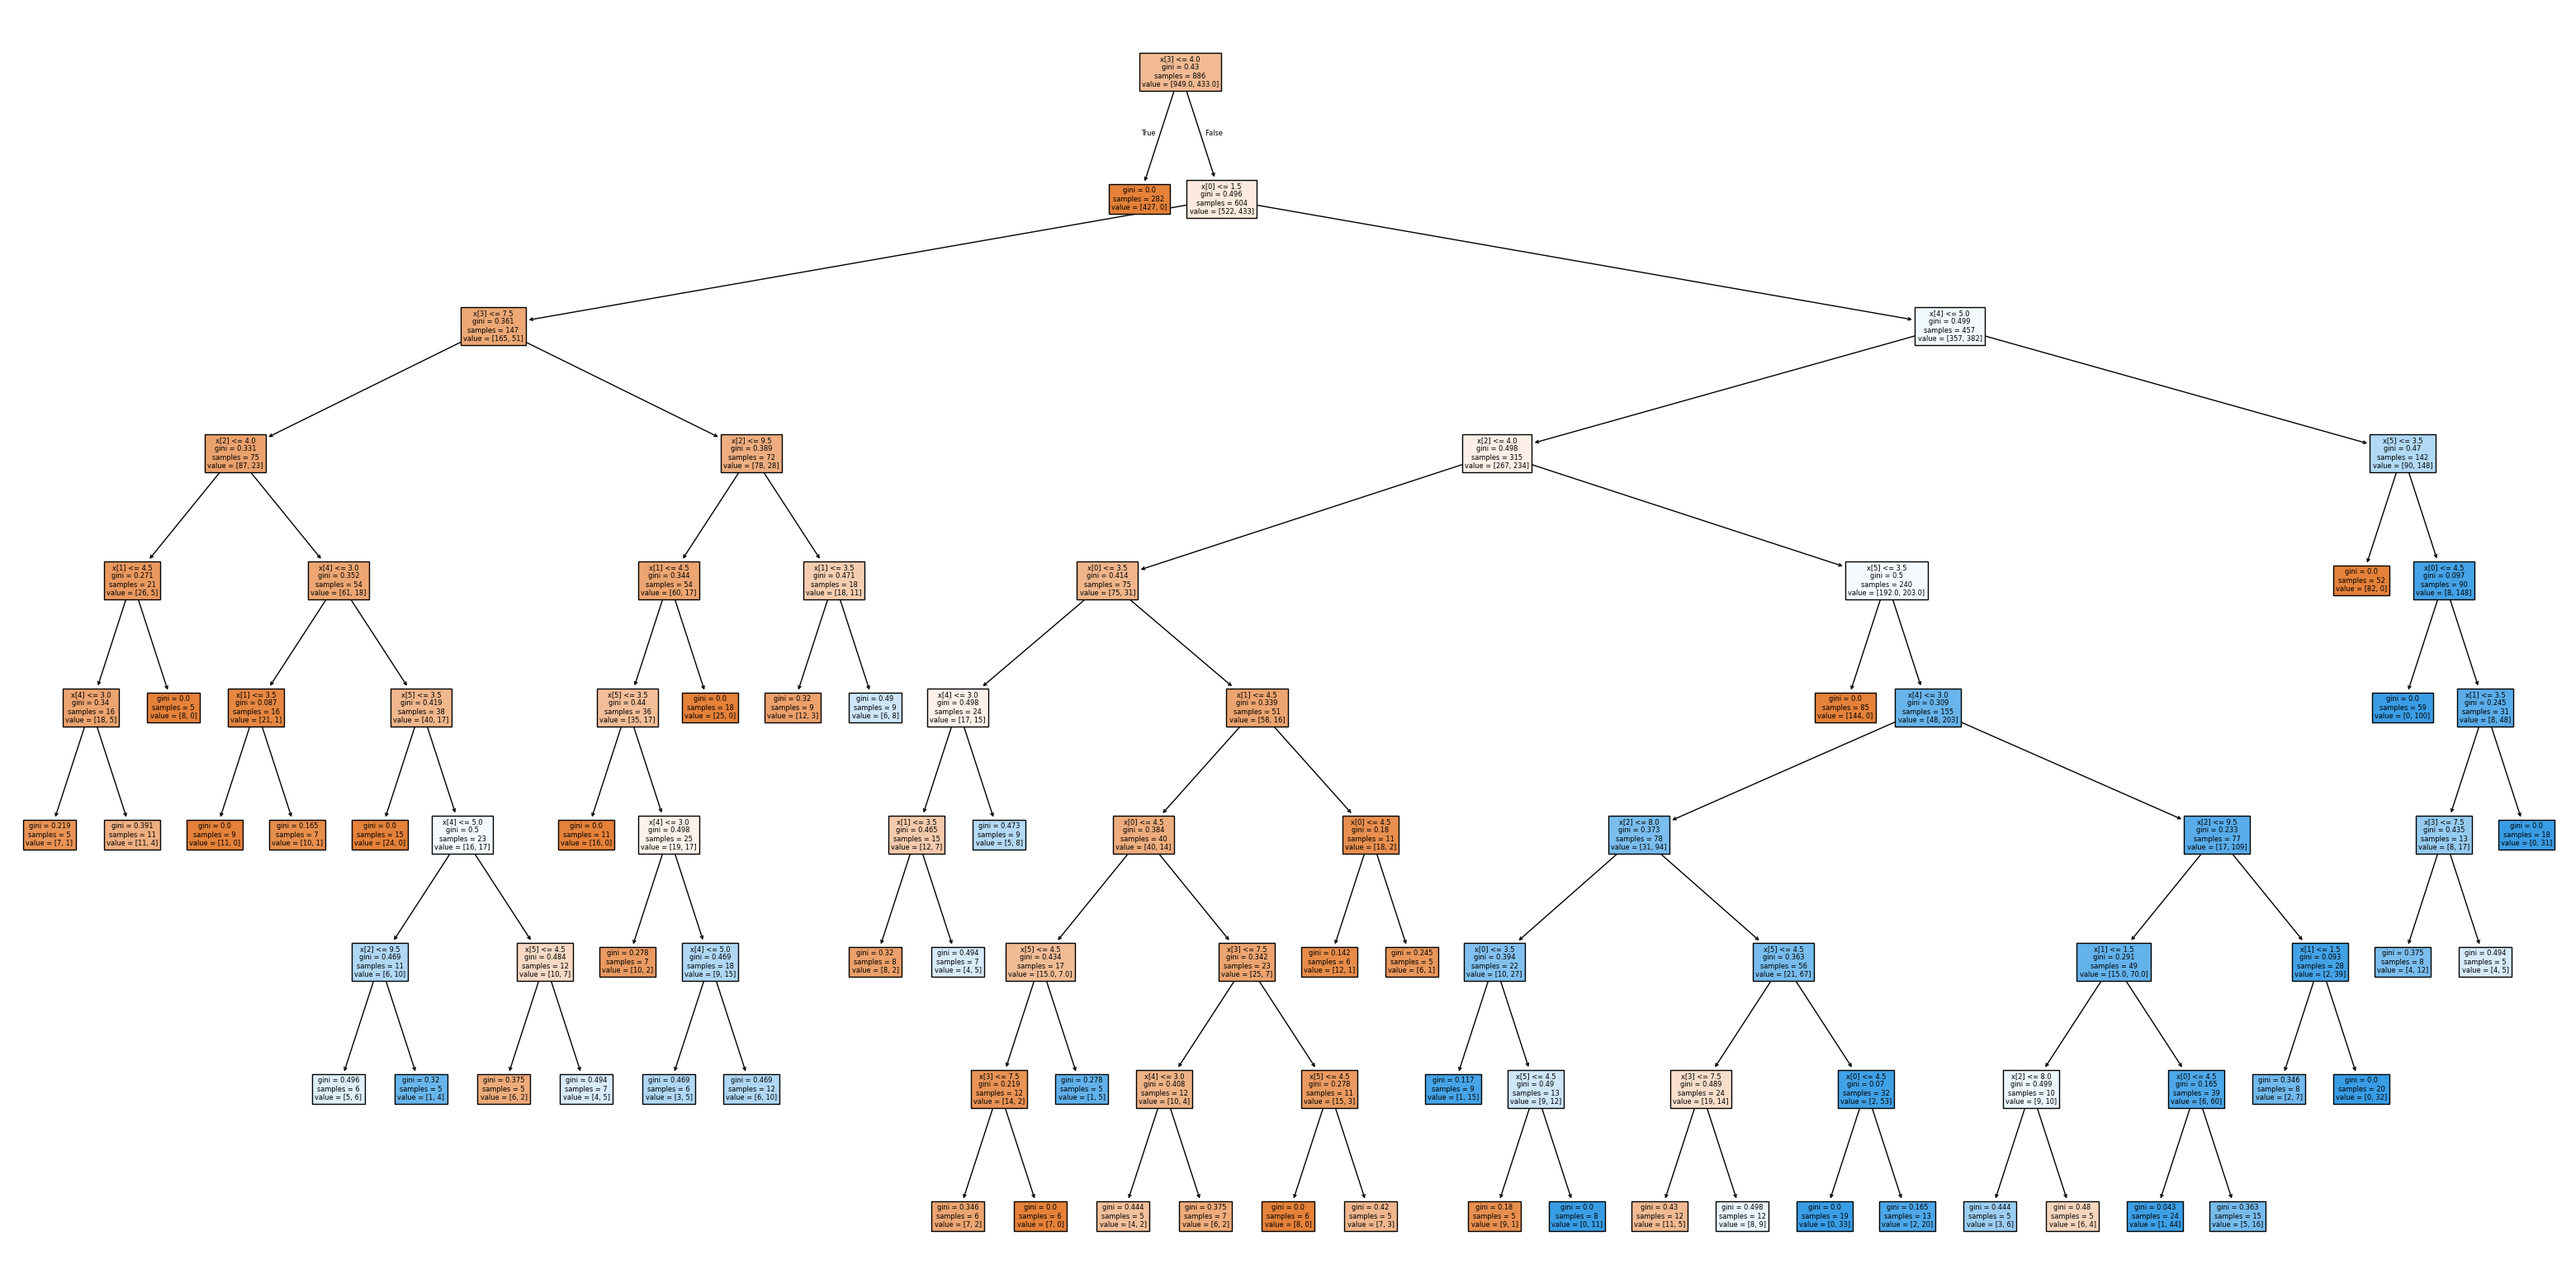

In [38]:
best_rfc = grid_search.best_estimator_
rf = plt.figure(figsize=(40, 20))
_ = tree.plot_tree(best_rfc.estimators_[0],
                   filled=True)
rf.savefig("random_forest_tree.png")

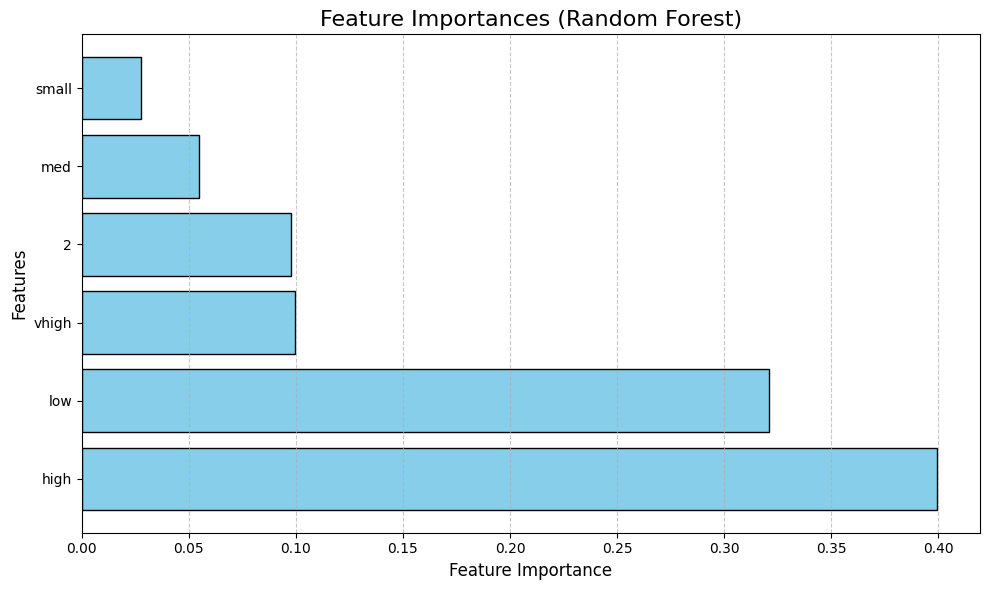

In [50]:
import numpy as np
# Rate importance
importances = best_rfc.feature_importances_
indices = np.argsort(importances)  # Indices of features sorted by importance
features = list(data_types.keys())

# Plot inverted bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices], align="center", color="skyblue", edgecolor="black")
plt.yticks(range(len(importances)), [features[i] for i in indices])
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importances (Random Forest)", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for most important at the top
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

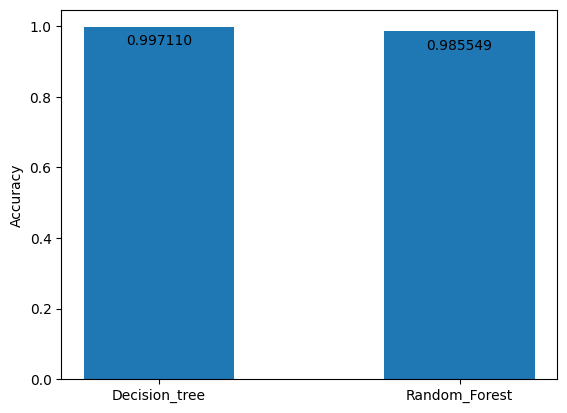

In [52]:
plt.figure()
barChart = plt.bar([0, 1], [dt_score, rfc_test_accuracy], width=0.5)
plt.bar_label(barChart, fmt='%.6f', padding=-15)
plt.xticks([0, 1], labels=["Decision_tree", "Random_Forest"])
plt.ylabel("Accuracy")
plt.show()